# Evaluation of network communications

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip

## About the Datasets
There are 3 datasets:
- **data3**: contains the data of the communication in one day without any anomalous behavior;
- **test3**: contains the data of the communication in one day with anomalous behavior;
- **servers3**: contains the data from external sources;

Each dataframe contains the following columns:
- `index`: the index of the row
- `timestamp`: the timestamp of the event
- `src_ip`: the source IP address
- `dst_ip`: the destination IP address
- `proto`: the protocol used
- `port`: the port used
- `up_bytes`: the number of bytes uploaded by the source
- `down_bytes`: the number of bytes downloaded by the source

In [152]:
non_anomalous_df = pd.read_parquet('datasets/dataset3/data3.parquet')
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')
servers_df = pd.read_parquet('datasets/dataset3/servers3.parquet')
non_anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
779943,957860,192.168.103.11,142.250.200.99,tcp,443,22243,228517
779944,957930,192.168.103.11,193.126.240.146,tcp,443,34885,199897
779945,958055,192.168.103.11,193.126.240.146,tcp,443,25383,216980
779946,958066,192.168.103.11,193.126.240.146,tcp,443,19162,99479
779947,958171,192.168.103.11,193.126.240.146,tcp,443,7247,60469


## Inside the Network
In this section, we will analyze the traffic flow inside the network. We will look at who communicates with whom, the protocols used, and look for any anomalies in the communication.

#### Protocols used
##### Transport Layer Protocols
The packets are divided into two protocols: TCP and UDP. As we can see in the following plot, the number of TCP packets is higher than the number of UDP packets, with almost 90% of the packets being TCP packets.

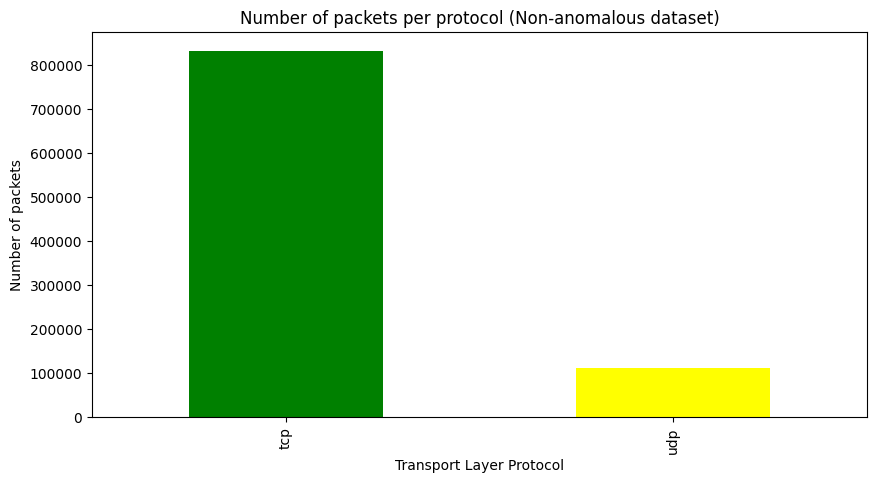

Ratio of TCP packets (Non-anomalous dataset): 0.8806493153897593
Ratio of UDP packets (Non-anomalous dataset): 0.11935068461024069


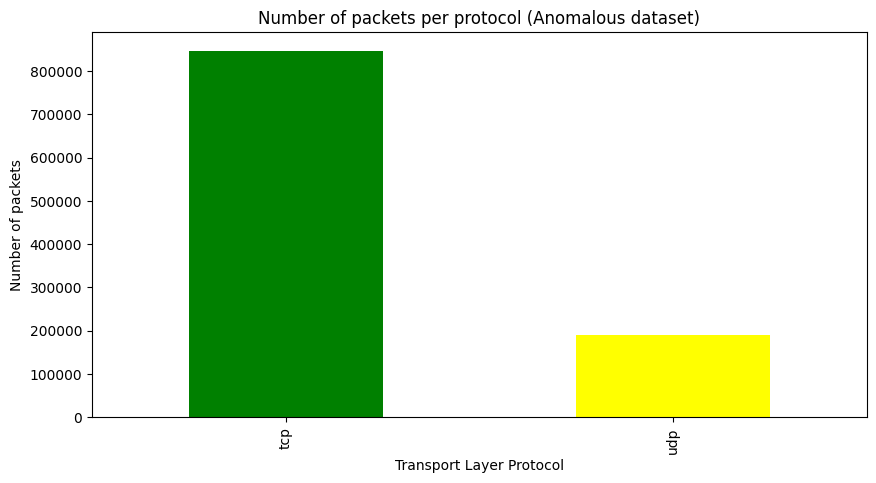

Ratio of TCP packets (Anomalous dataset): 0.816915101702591
Ratio of UDP packets (Anomalous dataset): 0.183084898297409


In [153]:
plt.figure(figsize=(10, 5))
non_anomalous_df['proto'].value_counts().plot(kind='bar', color=['green', 'yellow'])
plt.title('Number of packets per protocol (Non-anomalous dataset)')
plt.xlabel('Transport Layer Protocol')
plt.ylabel('Number of packets')
plt.show()

print('Ratio of TCP packets (Non-anomalous dataset):',
      len(non_anomalous_df[non_anomalous_df['proto'] == 'tcp']) / len(non_anomalous_df))
print('Ratio of UDP packets (Non-anomalous dataset):',
      len(non_anomalous_df[non_anomalous_df['proto'] == 'udp']) / len(non_anomalous_df))

plt.figure(figsize=(10, 5))
anomalous_df['proto'].value_counts().plot(kind='bar', color=['green', 'yellow'])
plt.title('Number of packets per protocol (Anomalous dataset)')
plt.xlabel('Transport Layer Protocol')
plt.ylabel('Number of packets')
plt.show()

print('Ratio of TCP packets (Anomalous dataset):',
      len(anomalous_df[anomalous_df['proto'] == 'tcp']) / len(anomalous_df))
print('Ratio of UDP packets (Anomalous dataset):',
      len(anomalous_df[anomalous_df['proto'] == 'udp']) / len(anomalous_df))


##### Application Layer Protocols

The following plot shows the number of packets per application layer protocol. All the packets are divided into 2 protocols: HTTPS and DNS. The number of DNS packets is lower than the number of HTTPS packets, with almost 90% of the packets being HTTPS packets. 

However, the anomalous datasets show a small difference between the number of DNS and HTTPS packets, with a higher number of DNS packets (7% more than the non-anomalous dataset). This could indicate attacks like DNS flooding.

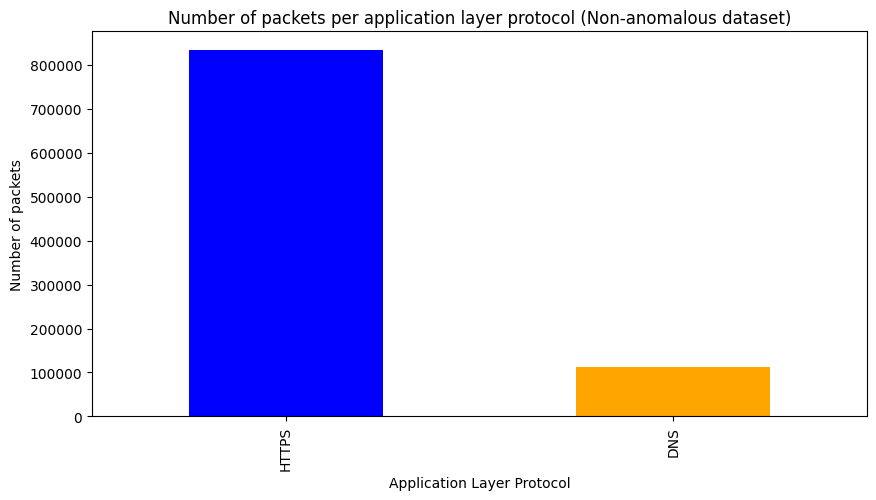

Ratio of HTTPS packets (Non-anomalous dataset): 0.8806493153897593
Ratio of DNS packets (Non-anomalous dataset): 0.11935068461024069


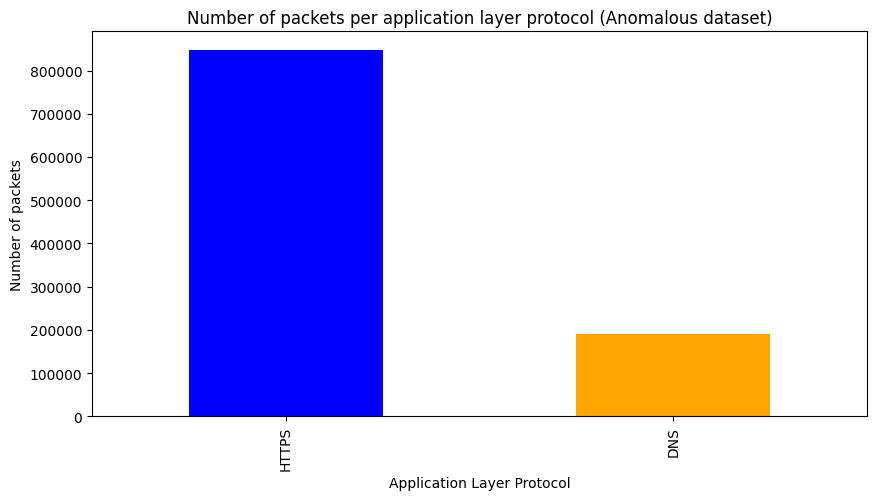

Ratio of HTTPS packets (Anomalous dataset): 0.816962315600821
Ratio of DNS packets (Anomalous dataset): 0.18303768439917906


In [154]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '53': 'DNS',
    '22': 'SSH',
    '21': 'FTP',
    '25': 'SMTP',
}

protocol_series = non_anomalous_df['port'].astype(str).map(application_protocols)

if protocol_series.isnull().values.any():
    protocol_series = non_anomalous_df['proto']

plt.figure(figsize=(10, 5))
protocol_series.value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Number of packets per application layer protocol (Non-anomalous dataset)')
plt.xlabel('Application Layer Protocol')
plt.ylabel('Number of packets')
plt.show()

print('Ratio of HTTPS packets (Non-anomalous dataset):',
      len(non_anomalous_df[non_anomalous_df['port'] == 443]) / len(non_anomalous_df))
print('Ratio of DNS packets (Non-anomalous dataset):',
      len(non_anomalous_df[non_anomalous_df['port'] == 53]) / len(non_anomalous_df))

protocol_series = anomalous_df['port'].astype(str).map(application_protocols)

if protocol_series.isnull().values.any():
    protocol_series = anomalous_df['proto']

plt.figure(figsize=(10, 5))
protocol_series.value_counts().plot(kind='bar', color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.title('Number of packets per application layer protocol (Anomalous dataset)')
plt.xlabel('Application Layer Protocol')
plt.ylabel('Number of packets')
plt.show()

print('Ratio of HTTPS packets (Anomalous dataset):', len(anomalous_df[anomalous_df['port'] == 443]) / len(anomalous_df))
print('Ratio of DNS packets (Anomalous dataset):', len(anomalous_df[anomalous_df['port'] == 53]) / len(anomalous_df))

### Packets sent (per Source IP)

The number of packets sent by the top 100 source IPs varies between the non-anomalous and anomalous datasets. 

As we can see, three machines have sent a higher number of packets in the **anomalous dataset**:
- **192.168.103.125**
- **192.168.103.90**

Pointing out that the machines could be compromised or used for malicious purposes.


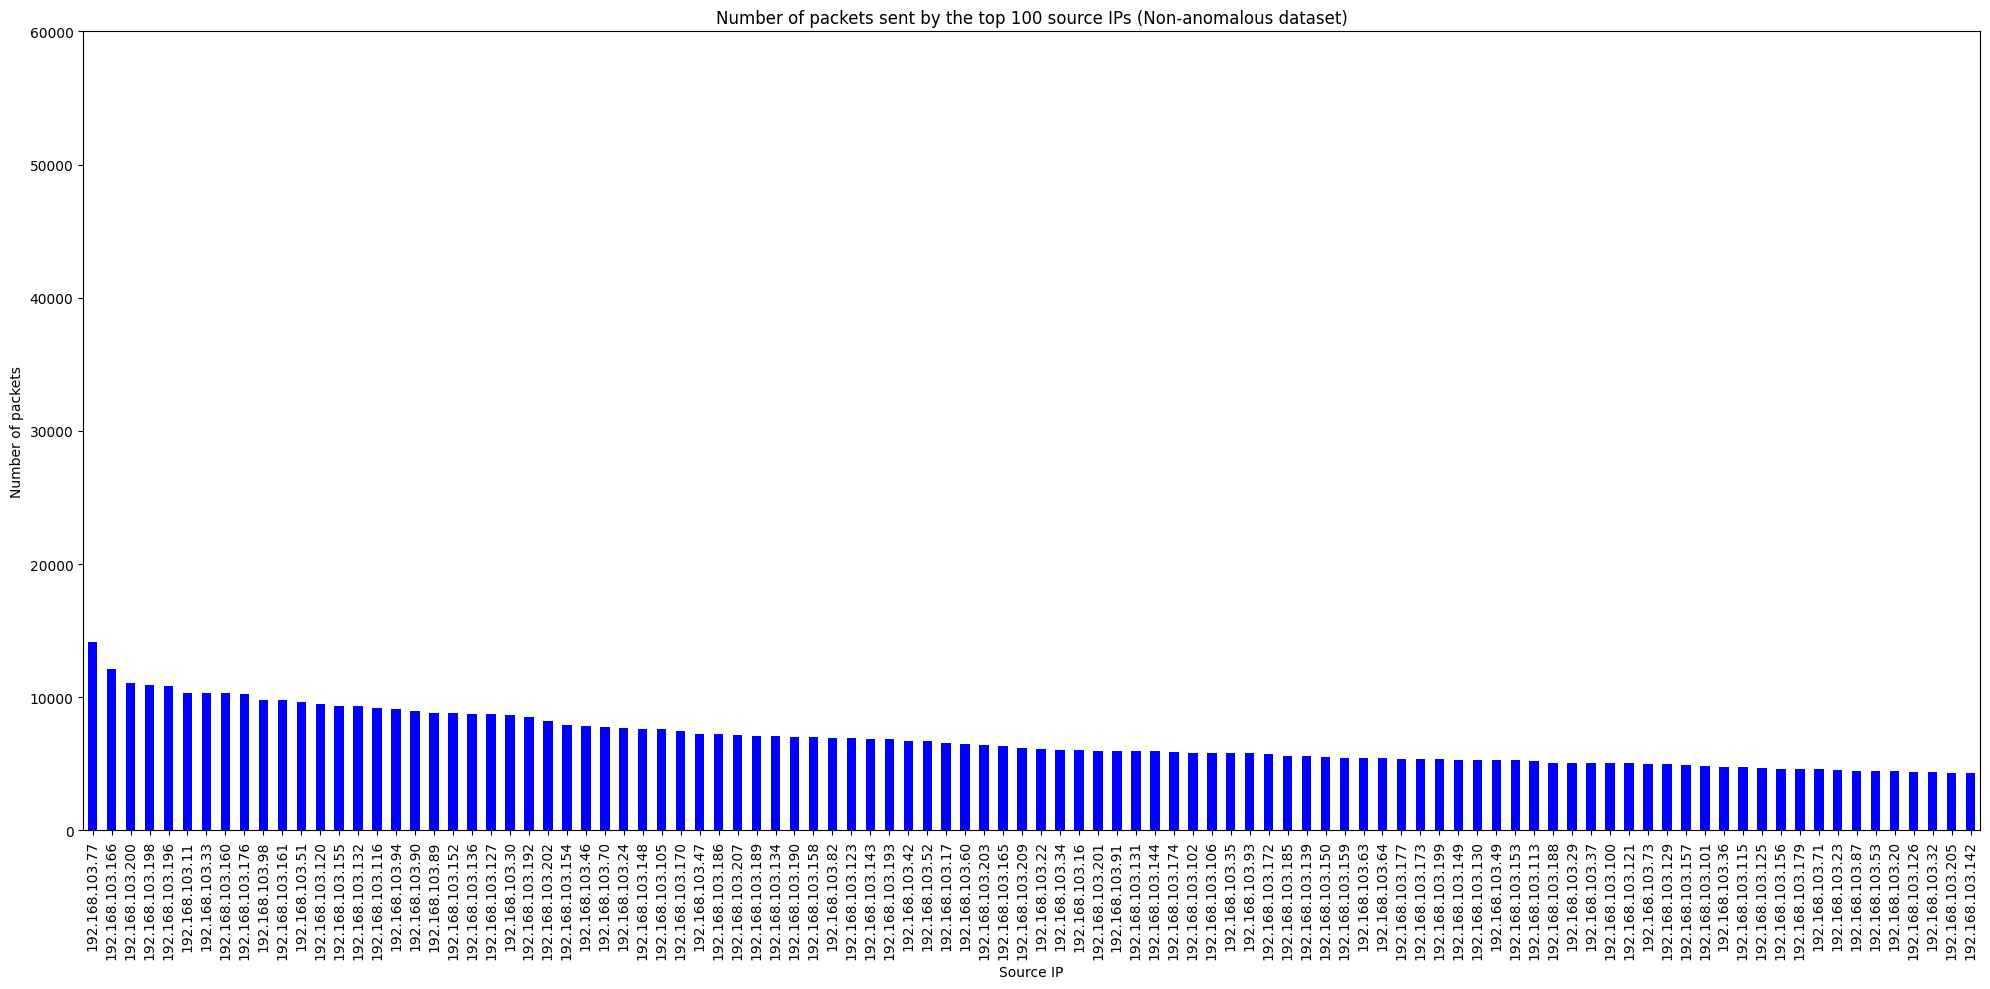

Top 10 source IPs (Non-anomalous dataset):

192.168.103.77 Packets sent: 14125
192.168.103.166 Packets sent: 12120
192.168.103.200 Packets sent: 11045
192.168.103.198 Packets sent: 10899
192.168.103.196 Packets sent: 10826
192.168.103.11 Packets sent: 10333
192.168.103.33 Packets sent: 10333
192.168.103.160 Packets sent: 10288
192.168.103.176 Packets sent: 10265
192.168.103.98 Packets sent: 9797


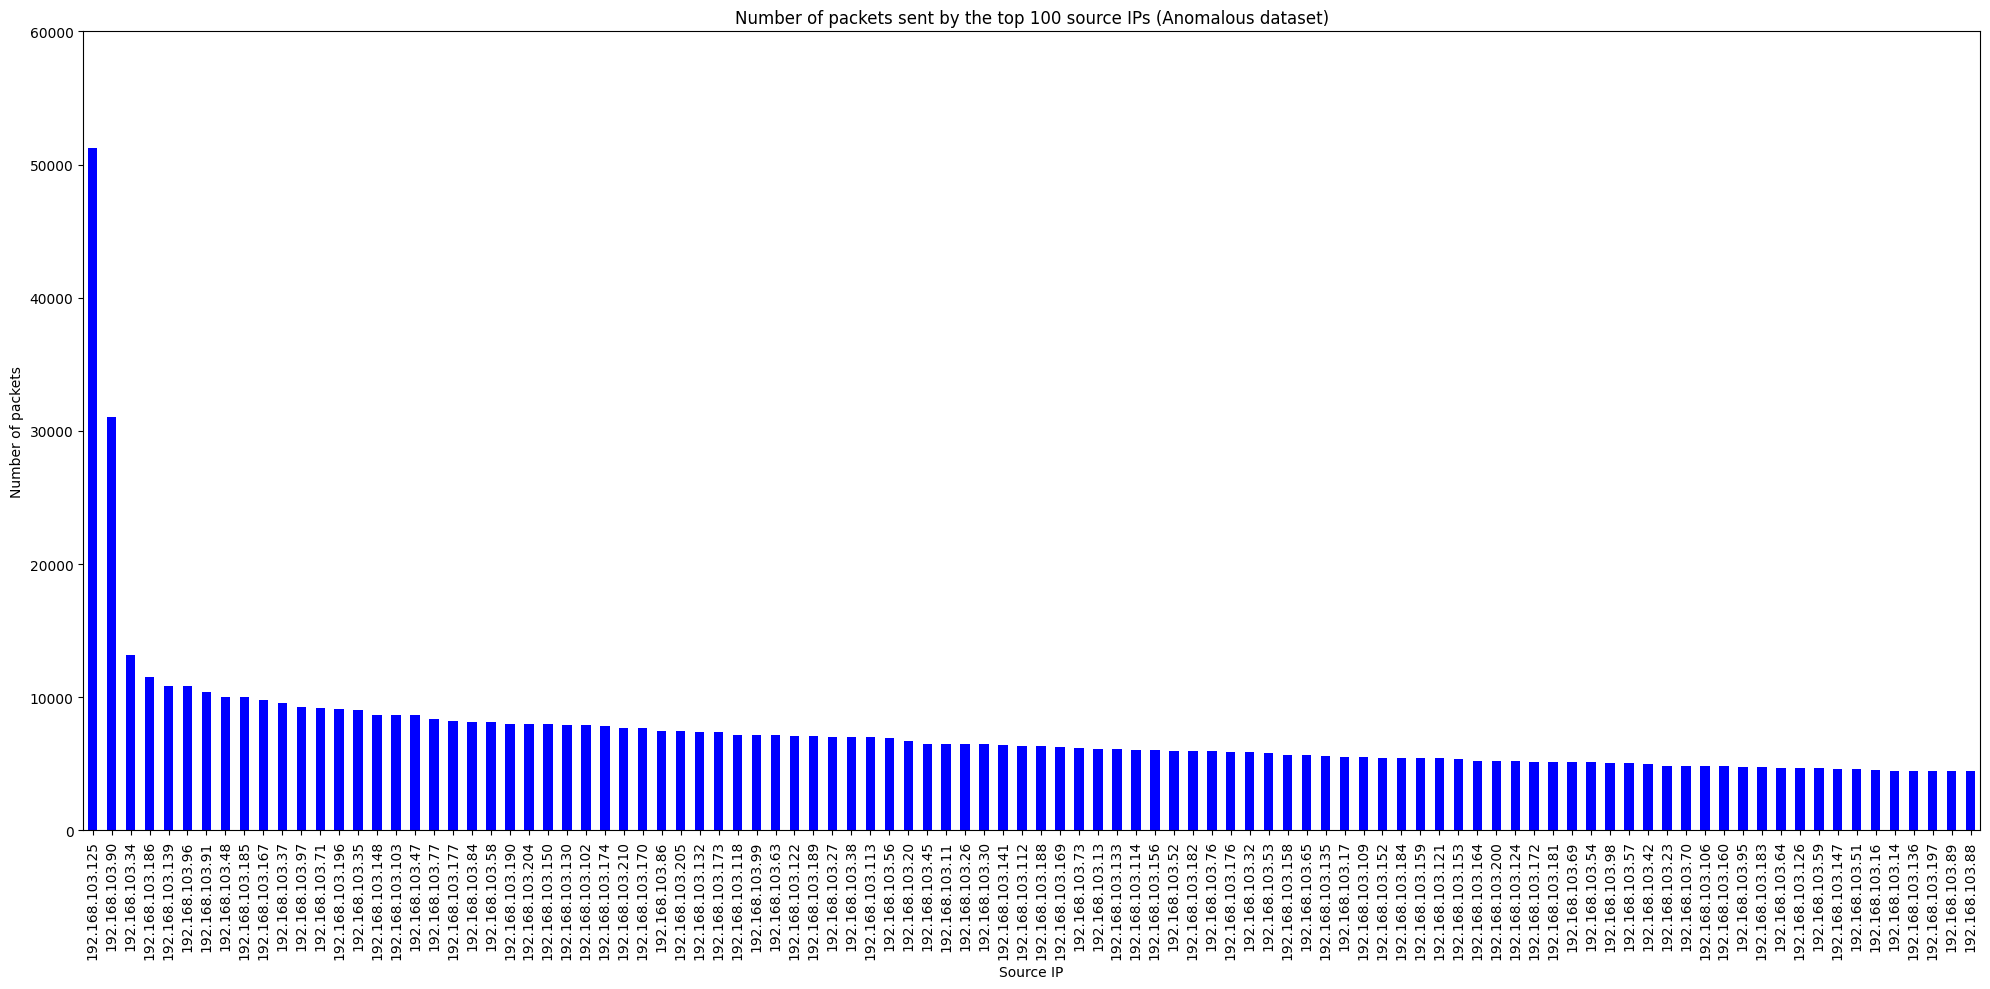

Top 10 source IPs (Anomalous dataset):

192.168.103.125 Packets sent: 51233
192.168.103.90 Packets sent: 31033
192.168.103.34 Packets sent: 13191
192.168.103.186 Packets sent: 11535
192.168.103.139 Packets sent: 10884
192.168.103.96 Packets sent: 10826
192.168.103.91 Packets sent: 10385
192.168.103.48 Packets sent: 10030
192.168.103.185 Packets sent: 10012
192.168.103.167 Packets sent: 9794


In [155]:
frequency = '1ms'
top_n = 100
y_lim = 60000

# NON-ANOMALOUS DATASET
non_anomalous_df['timestamp'] = pd.to_datetime(non_anomalous_df['timestamp'])
non_anomalous_df.set_index('timestamp', inplace=True)

# Group by 1 millisecond intervals, src_ip, and dst_ip, then count the number of packets
grouped = non_anomalous_df.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

# Aggregate the counts by src_ip
src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
top_src_ip_counts = src_ip_counts.head(top_n)

plt.figure(figsize=(20, 10))
top_src_ip_counts.plot(kind='bar', color='blue')
plt.title('Number of packets sent by the top 100 source IPs (Non-anomalous dataset)')
plt.xlabel('Source IP')
plt.ylabel('Number of packets')
plt.ylim(0, y_lim)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

print('Top 10 source IPs (Non-anomalous dataset):\n')
for ip, count in top_src_ip_counts.head(10).items():
    print(ip, "Packets sent:", count)

# ANOMALOUS DATASET
anomalous_df['timestamp'] = pd.to_datetime(anomalous_df['timestamp'])
anomalous_df.set_index('timestamp', inplace=True)

# Group by 1 millisecond intervals, src_ip, and dst_ip, then count the number of packets
grouped = anomalous_df.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

# Aggregate the counts by src_ip
src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
top_src_ip_counts = src_ip_counts.head(top_n)

plt.figure(figsize=(20, 10))
top_src_ip_counts.plot(kind='bar', color='blue')
plt.title('Number of packets sent by the top 100 source IPs (Anomalous dataset)')
plt.xlabel('Source IP')
plt.ylabel('Number of packets')
plt.ylim(0, y_lim)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.3)
plt.tight_layout()
plt.show()

print('Top 10 source IPs (Anomalous dataset):\n')
for ip, count in top_src_ip_counts.head(10).items():
    print(ip, "Packets sent:", count)

#### Downloads and Uploads